# Load the master table

In [1]:
from vulnerable_populations.pipeline import Granularity

granularity = Granularity.COUNTY_LEVEL

In [2]:
covid_19_master = catalog.load(f"mod_covid_19_{granularity.value}_master")
covid_19_master

2020-06-14 19:38:01,951 - kedro.io.data_catalog - INFO - Loading data from `mod_covid_19_county_level_master` (ParquetDataSet)...


,Insurance Type (Relevant for Clinical Data from Claims Only),FIPS County Code,County,State,State Code,Population,Deaths from COVID-19,Cases of COVID-19,Deaths from Covid 19 Per 100K Population,Cases of Covid 19 Per 100K Population,...,Children on Free or Reduced Lunch,American Indian or Alaska Native,Asian,Black or African American,Hispanic,Native Hawaiian or Other Pacific Islander,Non-Hispanic White,Other race,2 or more races,Racial / Ethnic Minority
0,All,49055,Wayne,Utah,UT,2690.0,0.0,0.0,0.0,0.0,...,0.500,0.003,0.005,0.003,0.059,0.013,0.912,0.000,0.006,0.083
1,All,21091,Hancock,Kentucky,KY,8758.0,0.0,7.0,0.0,79.0,...,0.510,0.001,0.007,0.009,0.015,0.000,0.956,0.000,0.011,0.033
2,All,27077,Lake of the Woods,Minnesota,MN,3758.0,0.0,0.0,0.0,0.0,...,0.532,0.003,0.008,0.000,0.017,0.000,0.930,0.000,0.041,0.028
3,All,19129,Mills,Iowa,IA,15063.0,0.0,22.0,0.0,146.0,...,0.347,0.007,0.003,0.009,0.030,0.000,0.943,0.000,0.008,0.049
4,All,49033,Rich,Utah,UT,2464.0,0.0,0.0,0.0,0.0,...,0.396,0.000,0.000,0.000,0.109,0.000,0.865,0.026,0.000,0.109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3133,All,22007,Assumption Parish,Louisiana,LA,22300.0,14.0,258.0,62.0,1156.0,...,0.681,0.004,0.002,0.299,0.029,0.000,0.656,0.000,0.011,0.333
3134,All,27093,Meeker,Minnesota,MN,23141.0,1.0,50.0,4.0,216.0,...,0.370,0.001,0.003,0.006,0.038,0.000,0.942,0.001,0.010,0.048
3135,All,37033,Caswell,North Carolina,NC,22698.0,1.0,101.0,4.0,444.0,...,0.809,0.002,0.007,0.329,0.038,0.002,0.612,0.000,0.010,0.378
3136,All,51053,Dinwiddie,Virginia,VA,28529.0,0.0,101.0,0.0,354.0,...,0.521,0.000,0.007,0.320,0.034,0.001,0.618,0.005,0.014,0.362


In [3]:
from datetime import datetime

from kedro.io.core import VERSION_FORMAT

last_load_version = datetime.strptime(
    getattr(
        catalog.datasets, f"raw_csbh_{granularity.value}_data"
    ).resolve_load_version(),
    VERSION_FORMAT,
)
print(
    "Center for Societal Benefit through Healthcare, McKinsey & Company. "
    "Vulnerable Populations Dashboard. https://csbh-dashboard.mckinsey.digital/#/. "
    f"Accessed on {last_load_version.date()}."
)

Center for Societal Benefit through Healthcare, McKinsey & Company. Vulnerable Populations Dashboard. https://csbh-dashboard.mckinsey.digital/#/. Accessed on 2020-06-13.


# Plot a diagonal correlation matrix

Adapted from https://seaborn.pydata.org/examples/many_pairwise_correlations.html.

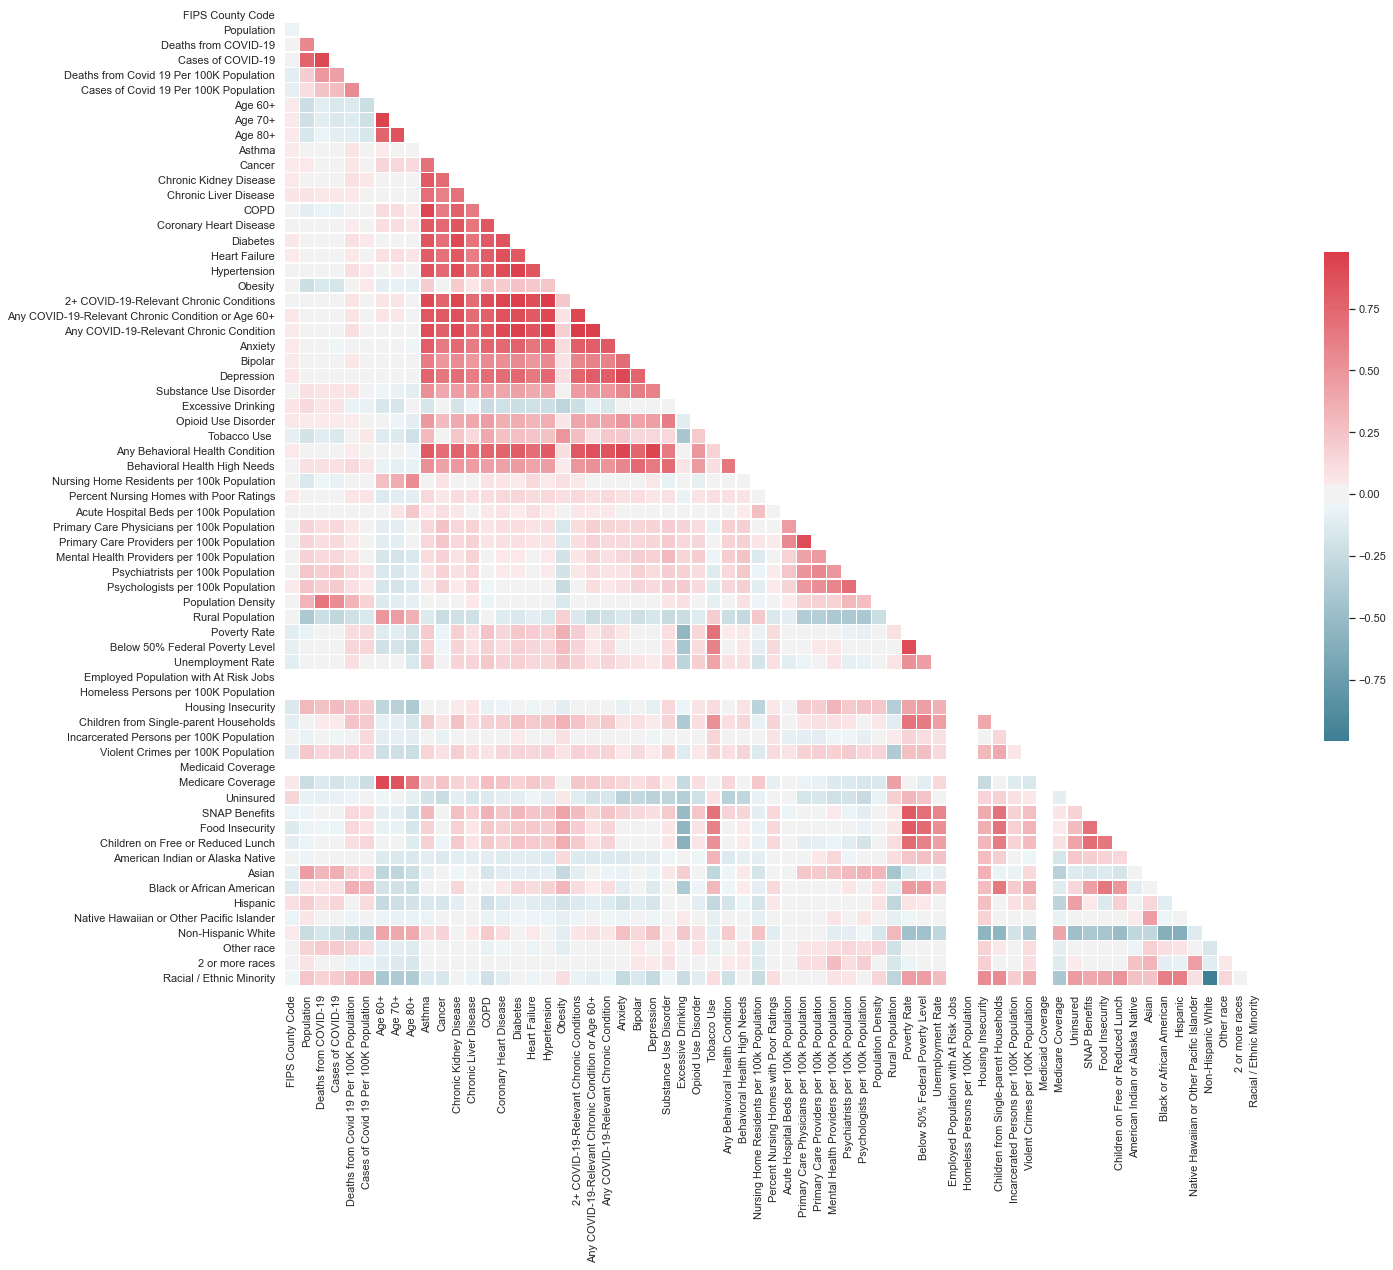

In [4]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

# Compute the correlation matrix
corr = covid_19_master.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(22, 18))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Split master table into feature matrix and selected target array

In [5]:
from enum import Enum


class Target(Enum):
    DEATHS = "Deaths from Covid 19 Per 100K Population"
    CASES = "Cases of Covid 19 Per 100K Population"

In [6]:
X = covid_19_master.loc[:, "Age 60+":]
y = covid_19_master[Target.CASES.value]
display(X, y)

,Age 60+,Age 70+,Age 80+,Asthma,Cancer,Chronic Kidney Disease,Chronic Liver Disease,COPD,Coronary Heart Disease,Diabetes,...,Children on Free or Reduced Lunch,American Indian or Alaska Native,Asian,Black or African American,Hispanic,Native Hawaiian or Other Pacific Islander,Non-Hispanic White,Other race,2 or more races,Racial / Ethnic Minority
0,0.282,0.138,0.036,0.026,0.026,0.018,0.009,0.018,0.019,0.029,...,0.500,0.003,0.005,0.003,0.059,0.013,0.912,0.000,0.006,0.083
1,0.229,0.111,0.032,0.038,0.019,0.044,0.011,0.035,0.065,0.084,...,0.510,0.001,0.007,0.009,0.015,0.000,0.956,0.000,0.011,0.033
2,0.320,0.142,0.053,0.045,0.019,0.038,0.006,0.045,0.064,0.064,...,0.532,0.003,0.008,0.000,0.017,0.000,0.930,0.000,0.041,0.028
3,0.248,0.108,0.043,0.046,0.028,0.056,0.009,0.041,0.075,0.088,...,0.347,0.007,0.003,0.009,0.030,0.000,0.943,0.000,0.008,0.049
4,0.237,0.125,0.040,0.046,0.009,0.028,0.009,0.019,0.019,0.037,...,0.396,0.000,0.000,0.000,0.109,0.000,0.865,0.026,0.000,0.109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3133,0.235,0.108,0.031,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.681,0.004,0.002,0.299,0.029,0.000,0.656,0.000,0.011,0.333
3134,0.267,0.132,0.048,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.370,0.001,0.003,0.006,0.038,0.000,0.942,0.001,0.010,0.048
3135,0.276,0.138,0.049,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.809,0.002,0.007,0.329,0.038,0.002,0.612,0.000,0.010,0.378
3136,0.229,0.104,0.035,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.521,0.000,0.007,0.320,0.034,0.001,0.618,0.005,0.014,0.362


0          0.0
1         79.0
2          0.0
3        146.0
4          0.0
         ...  
3133    1156.0
3134     216.0
3135     444.0
3136     354.0
3137     324.0
Name: Cases of Covid 19 Per 100K Population, Length: 3138, dtype: float64

# Visualize feature importances

Adapted from https://github.com/slundberg/shap#tree-ensemble-example-with-treeexplainer-xgboostlightgbmcatboostscikit-learnpyspark-models.

In [7]:
import xgboost
import shap

# load JS visualization code to notebook
shap.initjs()

# train XGBoost model
model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(X, label=y), 100)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
NPY_ARRAY_UPDATEIFCOPY, NPY_ARRAY_INOUT_ARRAY, and NPY_ARRAY_INOUT_FARRAY are deprecated, use NPY_WRITEBACKIFCOPY, NPY_ARRAY_INOUT_ARRAY2, or NPY_ARRAY_INOUT_FARRAY2 respectively instead, and call PyArray_ResolveWritebackIfCopy before the array is deallocated, i.e. before the last call to Py_DECREF.
UPDATEIFCOPY detected in array_dealloc.  Required call to PyArray_ResolveWritebackIfCopy or PyArray_DiscardWritebackIfCopy is missing


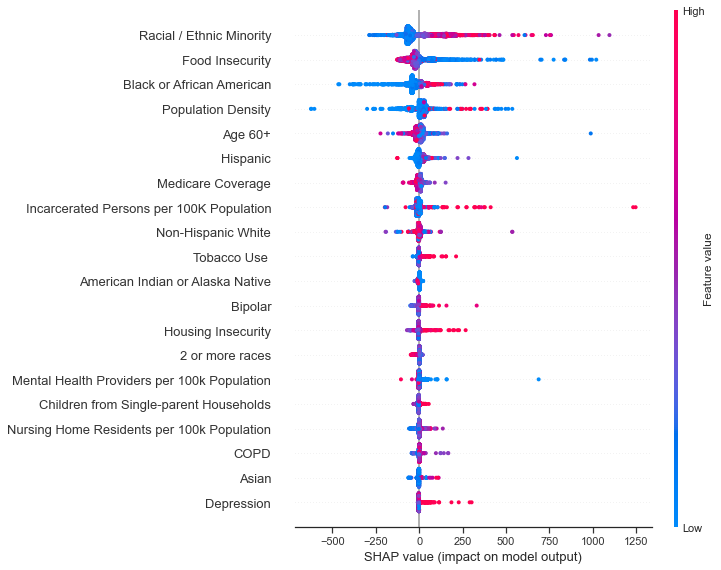

In [8]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X)

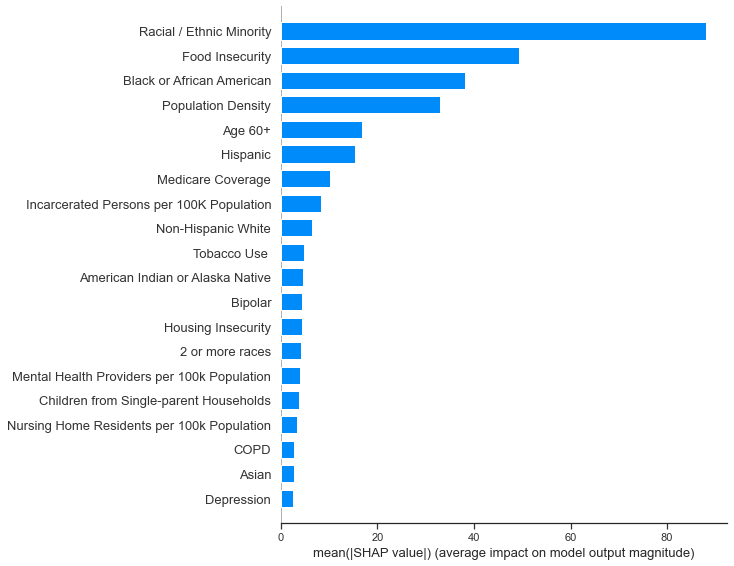

In [9]:
shap.summary_plot(shap_values, X, plot_type="bar")

# Print and plot evaluation metrics (before feature selection)

In [10]:
eval_result = xgboost.cv({"learning_rate": 0.01}, xgboost.DMatrix(X, label=y), 1000,
                         callbacks=[xgboost.callback.print_evaluation(show_stdv=True)])
eval_result.loc[eval_result["test-rmse-mean"].idxmin()]

[0]	train-rmse:752.46918+36.07931	test-rmse:751.45465+75.63556
[1]	train-rmse:747.90440+35.90895	test-rmse:748.60311+75.89436
[2]	train-rmse:743.39109+35.74231	test-rmse:745.77275+76.13308
[3]	train-rmse:738.87181+35.52384	test-rmse:743.09306+76.22459
[4]	train-rmse:734.40676+35.41571	test-rmse:740.30743+76.39169
[5]	train-rmse:730.00572+35.25402	test-rmse:737.86357+76.41122
[6]	train-rmse:725.81049+35.29375	test-rmse:735.38275+76.56672
[7]	train-rmse:721.51504+35.17372	test-rmse:732.86955+76.78526
[8]	train-rmse:717.34861+35.23091	test-rmse:730.42554+76.91498
[9]	train-rmse:713.14372+35.10260	test-rmse:728.01805+77.12688
[10]	train-rmse:709.14585+35.12633	test-rmse:725.72756+77.19571
[11]	train-rmse:705.01410+34.96218	test-rmse:723.36967+77.43146
[12]	train-rmse:700.90867+34.70788	test-rmse:721.17747+77.58888
[13]	train-rmse:696.92537+34.55430	test-rmse:718.95998+77.84389
[14]	train-rmse:692.96322+34.34334	test-rmse:716.72471+78.14512
[15]	train-rmse:688.97011+34.16948	test-rmse:714.6

[128]	train-rmse:412.03974+19.94294	test-rmse:606.40606+79.76193
[129]	train-rmse:410.47363+19.90615	test-rmse:606.07081+79.67875
[130]	train-rmse:408.96553+19.78254	test-rmse:605.81108+79.63989
[131]	train-rmse:407.50396+19.73434	test-rmse:605.55784+79.55086
[132]	train-rmse:406.06635+19.53807	test-rmse:605.14259+79.62778
[133]	train-rmse:404.70350+19.54801	test-rmse:604.66735+79.47654
[134]	train-rmse:403.33524+19.36743	test-rmse:604.37397+79.38327
[135]	train-rmse:401.95522+19.23742	test-rmse:604.05491+79.31722
[136]	train-rmse:400.55132+19.04906	test-rmse:603.78557+79.27777
[137]	train-rmse:399.10445+19.01750	test-rmse:603.47627+79.16054
[138]	train-rmse:397.85855+18.94272	test-rmse:603.21639+79.11020
[139]	train-rmse:396.49329+18.88276	test-rmse:602.77051+78.88901
[140]	train-rmse:395.13082+18.73121	test-rmse:602.33930+78.96228
[141]	train-rmse:393.81382+18.55921	test-rmse:601.90551+78.96233
[142]	train-rmse:392.43349+18.53198	test-rmse:601.69062+78.89859
[143]	train-rmse:391.1795

[255]	train-rmse:289.61097+17.01311	test-rmse:583.94706+70.44357
[256]	train-rmse:288.95918+16.95859	test-rmse:583.88810+70.33617
[257]	train-rmse:288.37447+17.00698	test-rmse:583.86961+70.31714
[258]	train-rmse:287.65573+17.03888	test-rmse:583.76836+70.19328
[259]	train-rmse:287.07200+17.16344	test-rmse:583.69777+70.15741
[260]	train-rmse:286.35492+17.20285	test-rmse:583.68157+70.08072
[261]	train-rmse:285.81174+17.25545	test-rmse:583.53290+69.97672
[262]	train-rmse:285.09303+17.25161	test-rmse:583.49936+69.94545
[263]	train-rmse:284.40591+17.20782	test-rmse:583.44108+69.91903
[264]	train-rmse:283.68843+17.24515	test-rmse:583.41669+69.84493
[265]	train-rmse:283.07055+17.14132	test-rmse:583.33664+69.75891
[266]	train-rmse:282.42952+17.11172	test-rmse:583.29649+69.69171
[267]	train-rmse:281.74568+17.19035	test-rmse:583.15866+69.65314
[268]	train-rmse:281.12446+17.19167	test-rmse:583.08353+69.70073
[269]	train-rmse:280.46725+17.17576	test-rmse:583.01104+69.61647
[270]	train-rmse:279.8987

[382]	train-rmse:230.74189+18.22358	test-rmse:579.17611+66.18364
[383]	train-rmse:230.42739+18.28310	test-rmse:579.18133+66.16587
[384]	train-rmse:230.00397+18.19444	test-rmse:579.19255+66.10653
[385]	train-rmse:229.80327+18.17642	test-rmse:579.22838+66.08730
[386]	train-rmse:229.51040+18.13133	test-rmse:579.24406+66.12068
[387]	train-rmse:229.19048+18.09516	test-rmse:579.24068+66.06964
[388]	train-rmse:228.86976+18.12499	test-rmse:579.22086+66.05683
[389]	train-rmse:228.63771+18.05663	test-rmse:579.25742+66.04382
[390]	train-rmse:228.36510+18.05241	test-rmse:579.21765+66.03835
[391]	train-rmse:228.12092+18.08378	test-rmse:579.22342+66.00201
[392]	train-rmse:227.77349+17.94873	test-rmse:579.24475+66.00231
[393]	train-rmse:227.40093+17.86693	test-rmse:579.25894+65.92287
[394]	train-rmse:227.04854+17.84471	test-rmse:579.26909+65.87151
[395]	train-rmse:226.78595+17.79950	test-rmse:579.26121+65.88892
[396]	train-rmse:226.52352+17.79159	test-rmse:579.21896+65.88420
[397]	train-rmse:226.2466

[509]	train-rmse:197.81917+18.21510	test-rmse:578.82881+64.49561
[510]	train-rmse:197.55661+18.18039	test-rmse:578.81445+64.46530
[511]	train-rmse:197.27063+18.10387	test-rmse:578.76846+64.46415
[512]	train-rmse:197.06230+18.07836	test-rmse:578.75345+64.47438
[513]	train-rmse:196.88090+18.05792	test-rmse:578.74328+64.47092
[514]	train-rmse:196.69273+18.10156	test-rmse:578.72788+64.47558
[515]	train-rmse:196.42672+18.04635	test-rmse:578.68281+64.47889
[516]	train-rmse:196.22002+17.97469	test-rmse:578.67210+64.47434
[517]	train-rmse:195.96300+18.00316	test-rmse:578.63949+64.47011
[518]	train-rmse:195.76059+17.95939	test-rmse:578.62467+64.45695
[519]	train-rmse:195.62029+17.94113	test-rmse:578.61925+64.47487
[520]	train-rmse:195.40611+17.95931	test-rmse:578.59663+64.46729
[521]	train-rmse:195.26941+17.95202	test-rmse:578.58230+64.45221
[522]	train-rmse:195.08295+17.94994	test-rmse:578.56054+64.46784
[523]	train-rmse:194.91776+18.00520	test-rmse:578.55182+64.45477
[524]	train-rmse:194.5796

[636]	train-rmse:174.23817+15.91344	test-rmse:577.42913+64.61518
[637]	train-rmse:174.03827+15.78219	test-rmse:577.42865+64.62565
[638]	train-rmse:173.88653+15.70026	test-rmse:577.42525+64.65295
[639]	train-rmse:173.67654+15.62251	test-rmse:577.39936+64.66144
[640]	train-rmse:173.48097+15.60281	test-rmse:577.38008+64.66870
[641]	train-rmse:173.35529+15.58879	test-rmse:577.37492+64.67261
[642]	train-rmse:173.05669+15.52933	test-rmse:577.36087+64.68795
[643]	train-rmse:172.85188+15.48347	test-rmse:577.35125+64.71396
[644]	train-rmse:172.62963+15.31288	test-rmse:577.36144+64.69892
[645]	train-rmse:172.53161+15.35313	test-rmse:577.34123+64.68416
[646]	train-rmse:172.25828+15.30681	test-rmse:577.31329+64.68851
[647]	train-rmse:172.09096+15.32009	test-rmse:577.30768+64.69207
[648]	train-rmse:171.92059+15.22234	test-rmse:577.31041+64.70851
[649]	train-rmse:171.73796+15.13219	test-rmse:577.28761+64.72582
[650]	train-rmse:171.56688+15.18126	test-rmse:577.25343+64.73168
[651]	train-rmse:171.3204

[763]	train-rmse:154.15341+10.77238	test-rmse:576.37568+64.87182
[764]	train-rmse:154.04957+10.80452	test-rmse:576.37390+64.88169
[765]	train-rmse:153.92490+10.75542	test-rmse:576.35346+64.89845
[766]	train-rmse:153.80861+10.71991	test-rmse:576.32822+64.90769
[767]	train-rmse:153.67897+10.66479	test-rmse:576.33558+64.89213
[768]	train-rmse:153.60163+10.66693	test-rmse:576.31453+64.88413
[769]	train-rmse:153.48858+10.72289	test-rmse:576.31194+64.88388
[770]	train-rmse:153.36649+10.72838	test-rmse:576.31391+64.88947
[771]	train-rmse:153.21292+10.69065	test-rmse:576.29939+64.89232
[772]	train-rmse:153.05557+10.66597	test-rmse:576.31838+64.88358
[773]	train-rmse:152.92530+10.62072	test-rmse:576.31584+64.88105
[774]	train-rmse:152.84046+10.62628	test-rmse:576.31572+64.88667
[775]	train-rmse:152.63303+10.58174	test-rmse:576.30839+64.86913
[776]	train-rmse:152.50991+10.58432	test-rmse:576.31358+64.88821
[777]	train-rmse:152.43578+10.59352	test-rmse:576.30024+64.89199
[778]	train-rmse:152.3364

[890]	train-rmse:139.25672+8.77679	test-rmse:576.00906+64.79534
[891]	train-rmse:139.14485+8.75016	test-rmse:575.99559+64.80675
[892]	train-rmse:139.02833+8.73262	test-rmse:576.00612+64.80373
[893]	train-rmse:138.92113+8.66968	test-rmse:576.02556+64.79782
[894]	train-rmse:138.76515+8.65700	test-rmse:576.03223+64.80883
[895]	train-rmse:138.66510+8.61195	test-rmse:576.02609+64.80360
[896]	train-rmse:138.57832+8.59315	test-rmse:576.02411+64.80604
[897]	train-rmse:138.47280+8.54923	test-rmse:576.02883+64.80614
[898]	train-rmse:138.33131+8.49849	test-rmse:576.03859+64.81153
[899]	train-rmse:138.21857+8.44014	test-rmse:576.05849+64.78793
[900]	train-rmse:138.14456+8.44860	test-rmse:576.06329+64.78606
[901]	train-rmse:138.00495+8.42628	test-rmse:576.03617+64.78465
[902]	train-rmse:137.86128+8.46846	test-rmse:576.02679+64.78930
[903]	train-rmse:137.71492+8.46994	test-rmse:576.02950+64.78308
[904]	train-rmse:137.59471+8.41327	test-rmse:576.03260+64.78484
[905]	train-rmse:137.45683+8.38038	test-

train-rmse-mean    135.659401
train-rmse-std       8.065791
test-rmse-mean     575.985891
test-rmse-std       64.676423
Name: 920, dtype: float64

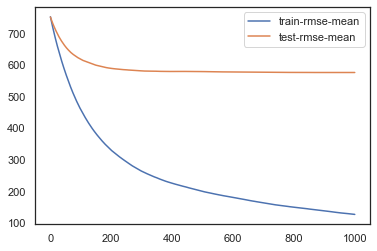

In [11]:
eval_result.plot(y=["train-rmse-mean", "test-rmse-mean"])

# Engineer and eliminate features

### Age

In [12]:
X["Age 60+"] -= X["Age 70+"]
X["Age 70+"] -= X["Age 80+"]
X.rename(columns={"Age 60+": "Age 60-69", "Age 70+": "Age 70-79"}, inplace=True)

### Chronic Conditions

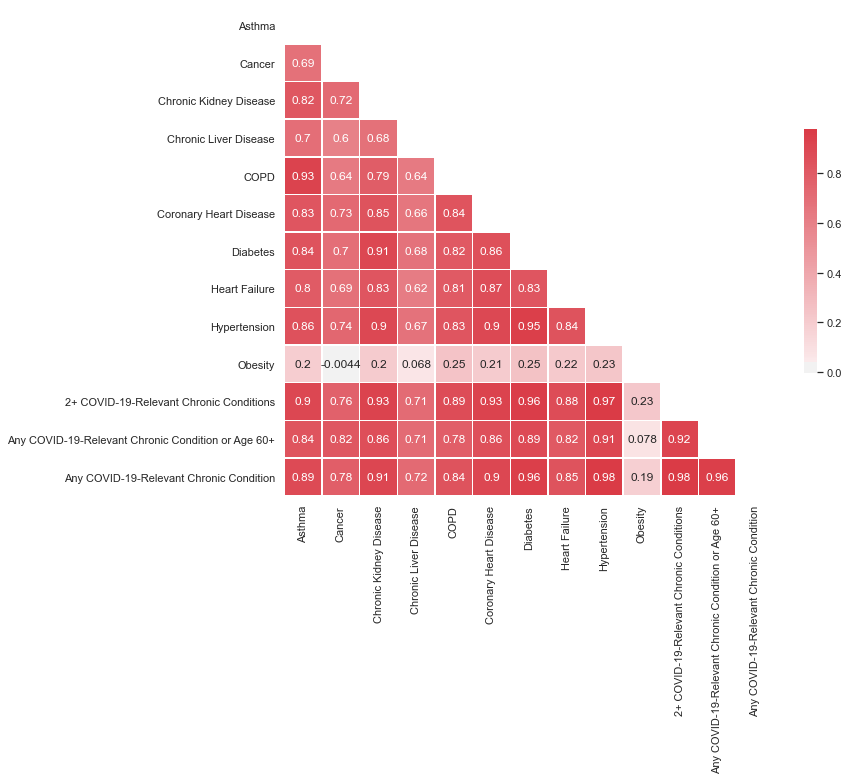

In [13]:
# Subset the correlation matrix
chronic_conditions_corr = covid_19_master.corr().loc[
    "Asthma":"Any COVID-19-Relevant Chronic Condition",
    "Asthma":"Any COVID-19-Relevant Chronic Condition",
]

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(chronic_conditions_corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(chronic_conditions_corr, mask=mask, cmap=cmap, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [14]:
X.drop(
    columns=[
        colname
        for colname in X.loc["Asthma":"Any COVID-19-Relevant Chronic Condition"].columns
        if colname in ["Obesity", "Any COVID-19-Relevant Chronic Condition"]
    ],
    inplace=True,
)

### Behavioral Health

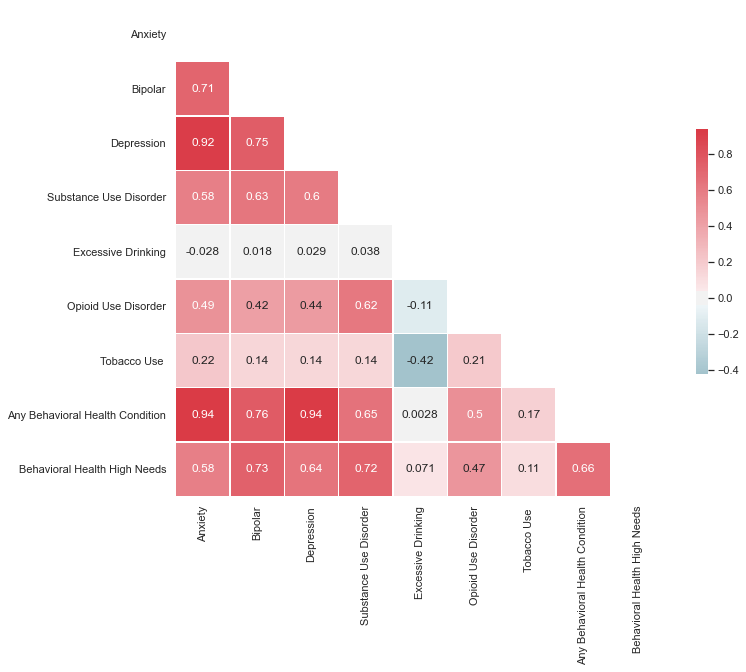

In [15]:
# Subset the correlation matrix
behavioral_health_corr = covid_19_master.corr().loc[
    "Anxiety":"Behavioral Health High Needs",
    "Anxiety":"Behavioral Health High Needs",
]

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(behavioral_health_corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(behavioral_health_corr, mask=mask, cmap=cmap, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [16]:
X.drop(columns="Any Behavioral Health Condition", inplace=True)

### Healthcare Supply

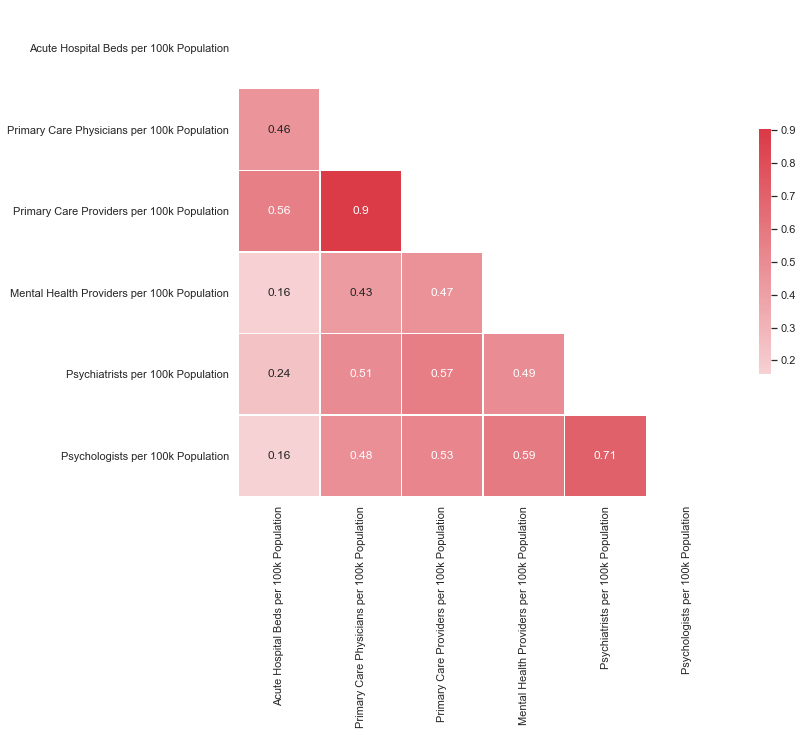

In [17]:
# Subset the correlation matrix
healthcare_supply_corr = covid_19_master.corr().loc[
    "Acute Hospital Beds per 100k Population":"Psychologists per 100k Population",
    "Acute Hospital Beds per 100k Population":"Psychologists per 100k Population",
]

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(healthcare_supply_corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(healthcare_supply_corr, mask=mask, cmap=cmap, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [18]:
X["Primary Care Providers per 100k Population"] -= X[
    "Primary Care Physicians per 100k Population"
]
X.rename(
    columns={
        "Primary Care Providers per 100k Population": "Primary Care Mid-Level Providers per 100k Population"
    },
    inplace=True,
)

### Social / Community Factors

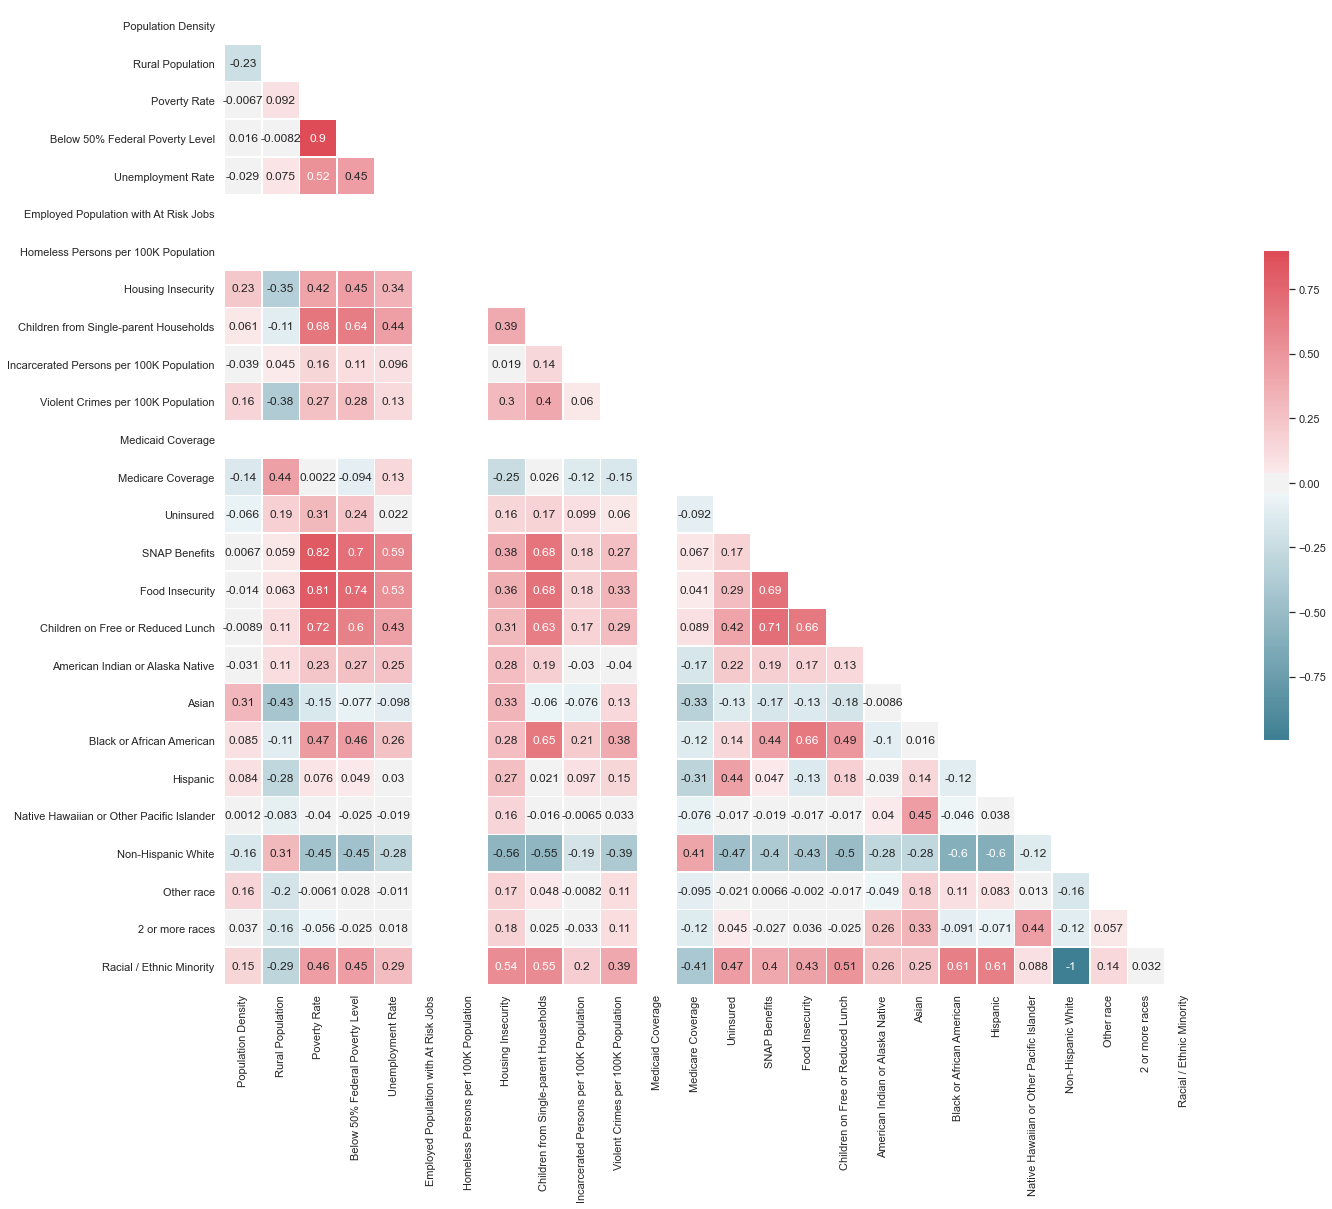

In [19]:
# Subset the correlation matrix
social_community_factors_corr = covid_19_master.corr().loc[
    "Population Density":, "Population Density":
]

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(social_community_factors_corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(22, 18))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(social_community_factors_corr, mask=mask, cmap=cmap, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [20]:
X["Poverty Rate"] -= X["Below 50% Federal Poverty Level"]
X.rename(
    columns={"Poverty Rate": "50-100% Federal Poverty Level"}, inplace=True,
)

In [21]:
X.drop(
    columns=["SNAP Benefits", "Food Insecurity", "Children on Free or Reduced Lunch"],
    inplace=True,
)

In [22]:
X.drop(columns="Racial / Ethnic Minority", inplace=True)

# Visualize feature importances (again!)

In [23]:
import xgboost
import shap

# load JS visualization code to notebook
shap.initjs()

# train XGBoost model
model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(X, label=y), 100)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
NPY_ARRAY_UPDATEIFCOPY, NPY_ARRAY_INOUT_ARRAY, and NPY_ARRAY_INOUT_FARRAY are deprecated, use NPY_WRITEBACKIFCOPY, NPY_ARRAY_INOUT_ARRAY2, or NPY_ARRAY_INOUT_FARRAY2 respectively instead, and call PyArray_ResolveWritebackIfCopy before the array is deallocated, i.e. before the last call to Py_DECREF.
UPDATEIFCOPY detected in array_dealloc.  Required call to PyArray_ResolveWritebackIfCopy or PyArray_DiscardWritebackIfCopy is missing


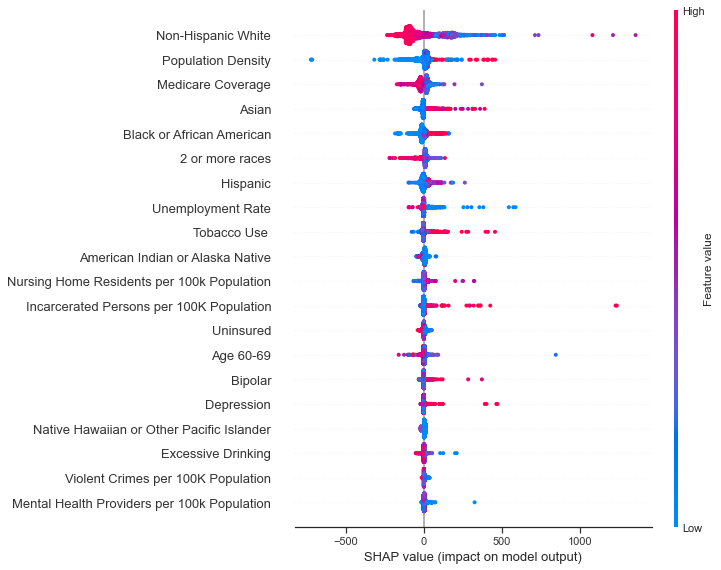

In [24]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X)

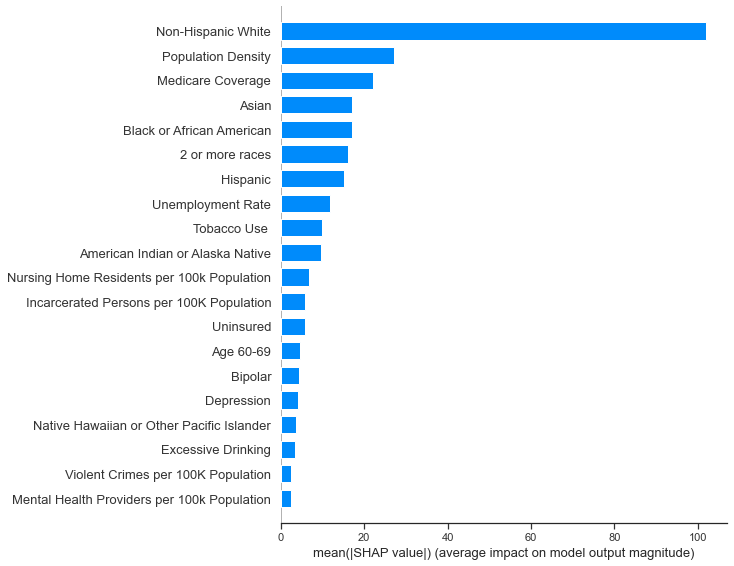

In [25]:
shap.summary_plot(shap_values, X, plot_type="bar")

# Print and plot evaluation metrics (after feature selection)

In [26]:
eval_result = xgboost.cv({"learning_rate": 0.01}, xgboost.DMatrix(X, label=y), 1000,
                         callbacks=[xgboost.callback.print_evaluation(show_stdv=True)])
eval_result.loc[eval_result["test-rmse-mean"].idxmin()]

[0]	train-rmse:752.93258+36.07117	test-rmse:751.50706+75.57191
[1]	train-rmse:748.70990+35.88819	test-rmse:748.88727+75.56827
[2]	train-rmse:744.56012+35.70645	test-rmse:746.27527+75.68286
[3]	train-rmse:740.45809+35.48662	test-rmse:743.87858+75.76817
[4]	train-rmse:736.40985+35.30170	test-rmse:741.24565+75.69767
[5]	train-rmse:732.35791+35.13063	test-rmse:738.97780+75.81774
[6]	train-rmse:728.33594+34.99273	test-rmse:736.48651+75.86819
[7]	train-rmse:724.43313+34.75817	test-rmse:734.10679+75.82988
[8]	train-rmse:720.55823+34.61041	test-rmse:731.78508+75.82931
[9]	train-rmse:716.76750+34.43684	test-rmse:729.62042+75.92160
[10]	train-rmse:712.86759+34.32421	test-rmse:727.34979+75.94337
[11]	train-rmse:709.12323+34.20342	test-rmse:725.12917+75.88959
[12]	train-rmse:705.47137+34.03384	test-rmse:722.96159+75.83888
[13]	train-rmse:701.74451+33.99375	test-rmse:720.85891+75.82702
[14]	train-rmse:698.06301+33.78999	test-rmse:718.78404+75.72183
[15]	train-rmse:694.53009+33.62477	test-rmse:716.7

[128]	train-rmse:427.02021+17.33968	test-rmse:610.66530+69.21112
[129]	train-rmse:425.55439+17.24578	test-rmse:610.35628+69.03562
[130]	train-rmse:424.13648+17.16854	test-rmse:609.82202+69.05007
[131]	train-rmse:422.70536+16.99616	test-rmse:609.34117+68.84932
[132]	train-rmse:421.31836+16.91038	test-rmse:608.83879+68.87068
[133]	train-rmse:419.94699+16.69764	test-rmse:608.45404+68.72249
[134]	train-rmse:418.59231+16.49184	test-rmse:608.07456+68.57599
[135]	train-rmse:417.23304+16.39847	test-rmse:607.70079+68.62196
[136]	train-rmse:415.84522+16.25566	test-rmse:607.38768+68.46764
[137]	train-rmse:414.49106+16.20621	test-rmse:606.84841+68.45793
[138]	train-rmse:413.11591+16.08271	test-rmse:606.51729+68.29668
[139]	train-rmse:411.72997+15.97825	test-rmse:606.14327+68.08162
[140]	train-rmse:410.34175+15.94215	test-rmse:605.76093+68.08854
[141]	train-rmse:409.01982+15.80204	test-rmse:605.43591+67.86861
[142]	train-rmse:407.67340+15.75224	test-rmse:605.16099+67.92777
[143]	train-rmse:406.2774

[255]	train-rmse:299.47938+8.43086	test-rmse:588.93664+60.07436
[256]	train-rmse:298.82558+8.52765	test-rmse:588.87659+59.96934
[257]	train-rmse:298.16869+8.39099	test-rmse:588.77868+60.02860
[258]	train-rmse:297.52237+8.40614	test-rmse:588.84241+60.03819
[259]	train-rmse:296.92371+8.20251	test-rmse:588.71217+60.04853
[260]	train-rmse:296.31167+8.30723	test-rmse:588.68213+59.92928
[261]	train-rmse:295.52953+8.27572	test-rmse:588.63166+59.82465
[262]	train-rmse:294.89322+8.35045	test-rmse:588.55617+59.70697
[263]	train-rmse:294.24969+8.41169	test-rmse:588.54388+59.58154
[264]	train-rmse:293.60280+8.24134	test-rmse:588.50573+59.59464
[265]	train-rmse:293.00133+8.26204	test-rmse:588.39253+59.46348
[266]	train-rmse:292.36040+8.31094	test-rmse:588.32184+59.34834
[267]	train-rmse:291.73286+8.41511	test-rmse:588.27089+59.23674
[268]	train-rmse:291.07141+8.20886	test-rmse:588.23543+59.26285
[269]	train-rmse:290.58405+8.31483	test-rmse:588.11798+59.13999
[270]	train-rmse:289.99994+8.40859	test-

[383]	train-rmse:235.44490+9.62267	test-rmse:585.32904+56.24363
[384]	train-rmse:235.16999+9.68234	test-rmse:585.33350+56.21595
[385]	train-rmse:234.79684+9.68937	test-rmse:585.28255+56.18133
[386]	train-rmse:234.51173+9.75220	test-rmse:585.30839+56.14712
[387]	train-rmse:234.13516+9.77924	test-rmse:585.32829+56.16458
[388]	train-rmse:233.70870+9.80292	test-rmse:585.39819+56.10219
[389]	train-rmse:233.36352+9.74920	test-rmse:585.41868+56.12696
[390]	train-rmse:232.96808+9.82143	test-rmse:585.37604+56.07448
[391]	train-rmse:232.61994+9.90236	test-rmse:585.30682+56.07217
[392]	train-rmse:232.21577+9.81100	test-rmse:585.25881+56.10278
[393]	train-rmse:232.03394+9.89127	test-rmse:585.23751+56.06610
[394]	train-rmse:231.59837+9.92730	test-rmse:585.22272+56.06319
[395]	train-rmse:231.22067+9.97603	test-rmse:585.25757+56.08140
[396]	train-rmse:230.74918+9.92401	test-rmse:585.29218+56.11050
[397]	train-rmse:230.32802+9.96226	test-rmse:585.20494+56.08040
[398]	train-rmse:230.01550+9.94372	test-

[510]	train-rmse:202.07286+10.23552	test-rmse:584.34705+54.34970
[511]	train-rmse:201.90704+10.18382	test-rmse:584.34127+54.34744
[512]	train-rmse:201.73022+10.15679	test-rmse:584.32363+54.35361
[513]	train-rmse:201.50681+10.09593	test-rmse:584.29258+54.36204
[514]	train-rmse:201.34619+10.07527	test-rmse:584.29722+54.34866
[515]	train-rmse:201.19801+10.09596	test-rmse:584.30019+54.35706
[516]	train-rmse:201.02020+10.15289	test-rmse:584.25157+54.32995
[517]	train-rmse:200.84677+10.12894	test-rmse:584.26459+54.30992
[518]	train-rmse:200.64066+10.06867	test-rmse:584.26882+54.31458
[519]	train-rmse:200.52772+10.08508	test-rmse:584.27677+54.31120
[520]	train-rmse:200.40623+10.07003	test-rmse:584.27863+54.31091
[521]	train-rmse:200.15798+10.06773	test-rmse:584.26200+54.31407
[522]	train-rmse:199.99385+10.03158	test-rmse:584.25854+54.27946
[523]	train-rmse:199.82114+10.08775	test-rmse:584.22176+54.25943
[524]	train-rmse:199.65285+10.10123	test-rmse:584.21873+54.27907
[525]	train-rmse:199.4646

[638]	train-rmse:180.07717+8.19579	test-rmse:583.58848+54.33312
[639]	train-rmse:179.89043+8.20489	test-rmse:583.57007+54.35055
[640]	train-rmse:179.74654+8.19786	test-rmse:583.52352+54.35152
[641]	train-rmse:179.50356+8.10655	test-rmse:583.48818+54.32465
[642]	train-rmse:179.32467+8.13045	test-rmse:583.50096+54.31645
[643]	train-rmse:179.20068+8.13222	test-rmse:583.51308+54.30241
[644]	train-rmse:179.03089+8.07646	test-rmse:583.50299+54.31273
[645]	train-rmse:178.89109+8.06378	test-rmse:583.46427+54.23435
[646]	train-rmse:178.76102+8.05262	test-rmse:583.45150+54.23391
[647]	train-rmse:178.53944+7.94539	test-rmse:583.41642+54.26708
[648]	train-rmse:178.32212+7.93966	test-rmse:583.41538+54.27277
[649]	train-rmse:178.16792+7.94194	test-rmse:583.39807+54.27705
[650]	train-rmse:178.04034+7.92562	test-rmse:583.40228+54.27556
[651]	train-rmse:177.90011+7.87255	test-rmse:583.40786+54.27970
[652]	train-rmse:177.67516+7.88096	test-rmse:583.37069+54.28275
[653]	train-rmse:177.45150+7.78056	test-

[767]	train-rmse:161.70284+6.00668	test-rmse:582.82863+54.35354
[768]	train-rmse:161.63696+5.99572	test-rmse:582.83319+54.35110
[769]	train-rmse:161.49601+6.01317	test-rmse:582.79974+54.34054
[770]	train-rmse:161.35166+6.01840	test-rmse:582.79098+54.35726
[771]	train-rmse:161.21036+5.99228	test-rmse:582.79059+54.36286
[772]	train-rmse:161.13255+6.00102	test-rmse:582.78965+54.36991
[773]	train-rmse:161.03571+5.99085	test-rmse:582.77474+54.39583
[774]	train-rmse:160.85605+6.01365	test-rmse:582.76363+54.39824
[775]	train-rmse:160.74015+6.02885	test-rmse:582.76823+54.39236
[776]	train-rmse:160.65817+6.02388	test-rmse:582.76558+54.38826
[777]	train-rmse:160.44856+6.01886	test-rmse:582.75441+54.40957
[778]	train-rmse:160.29472+6.00991	test-rmse:582.76713+54.41704
[779]	train-rmse:160.21323+5.98147	test-rmse:582.75183+54.43498
[780]	train-rmse:160.08808+5.97386	test-rmse:582.73785+54.44771
[781]	train-rmse:159.99162+5.97117	test-rmse:582.72634+54.46692
[782]	train-rmse:159.85899+5.98897	test-

[896]	train-rmse:145.96904+6.41542	test-rmse:582.25081+54.47578
[897]	train-rmse:145.84054+6.42777	test-rmse:582.24504+54.47857
[898]	train-rmse:145.74359+6.42387	test-rmse:582.23871+54.48762
[899]	train-rmse:145.61457+6.38014	test-rmse:582.22402+54.49253
[900]	train-rmse:145.52541+6.40820	test-rmse:582.23446+54.48771
[901]	train-rmse:145.39379+6.36862	test-rmse:582.21407+54.49586
[902]	train-rmse:145.25331+6.36854	test-rmse:582.20872+54.49085
[903]	train-rmse:145.08729+6.36205	test-rmse:582.20703+54.48882
[904]	train-rmse:144.97952+6.38429	test-rmse:582.20522+54.48871
[905]	train-rmse:144.88456+6.41413	test-rmse:582.18199+54.48617
[906]	train-rmse:144.77048+6.38598	test-rmse:582.18774+54.47523
[907]	train-rmse:144.65422+6.37552	test-rmse:582.18783+54.47458
[908]	train-rmse:144.56494+6.36334	test-rmse:582.18638+54.47864
[909]	train-rmse:144.47411+6.39339	test-rmse:582.17930+54.48026
[910]	train-rmse:144.37904+6.40689	test-rmse:582.18357+54.47050
[911]	train-rmse:144.21473+6.40152	test-

train-rmse-mean    134.557327
train-rmse-std       6.774802
test-rmse-mean     582.004476
test-rmse-std       54.472716
Name: 998, dtype: float64

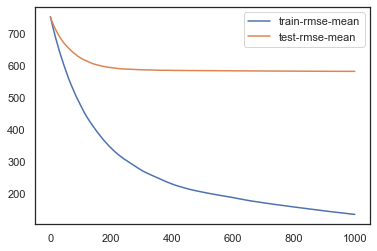

In [27]:
eval_result.plot(y=["train-rmse-mean", "test-rmse-mean"])